# Übung 1: Backpropagation für Mehrschichtenperzeptronen

In [1]:
import os, sys, importlib, math
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [2]:
# Load modules from modules directory
base_path_modules = os.path.join(os.getcwd(), "..", "modules")
sys.path.append(base_path_modules)
import load_mnist
importlib.reload(load_mnist)

<module 'load_mnist' from '/home/jovyan/work/../modules/load_mnist.py'>

### 1. Spielzeugdatensatz

Laden Sie sich das Jupyter-Notebook "Training eines MLPs auf MNIST" von der Vorlesungsseite auf Moodle herunter, das den Numpy-Code für den Backpropagation-Agortihmus für den MLPs enthält. Statt auf MNIST werden wir zunächst ein einfacheres Perzeptron auf den Spielzeugdaten aus der Vorlesung trainieren.

#### Vorgehensweise:
1. Erzeugen Sie 200 zweidimensionale Trainingsdatenpunkte mithilfe einer Gleichverteilung über dem Gebiet [-6,6]  x [-6,6]. Speichern Sie diese in einer 200 x 2 Designmatrix.
2. Die Klassenlabels 0 und 1 werden so vergeben, dass alle Datenpunkte im 1. und 3. Quadranten das Label 1 und im 2. und 4. Quadranten das Label 0 erhalten. Speichern Sie die Labels in einem Array.
3. Erzeugen Sie einen gleich großen Testdatensatz nach demselben Prinzip stellen Sie beide Datensätze zur Überprüfung als Scatterplot dar.

In [3]:
# Uniformly distributed training-data over intervall [-6, 6]
x_train = np.random.uniform(-6, 6, (200, 2))
x_train

array([[-2.16361812, -5.22374487],
       [-2.38650532, -2.54346638],
       [-5.42683821,  1.80992414],
       [ 5.8676085 , -3.3650697 ],
       [ 4.33779827, -2.13236668],
       [-1.39127051, -0.81394617],
       [-0.6130483 ,  3.04545498],
       [-0.23023344, -0.34171141],
       [-5.99790889,  4.09096326],
       [ 1.55052596, -1.86856839],
       [-0.75953363,  0.61487188],
       [ 3.99303333, -3.22034087],
       [ 1.2811418 ,  3.07313742],
       [ 2.29126267,  4.67865621],
       [-5.47045476, -1.40950173],
       [-5.98022026, -3.49041409],
       [-2.30187509,  0.13263735],
       [ 1.61663006, -3.61652109],
       [ 5.05328779,  5.82964313],
       [ 5.11296025, -5.4232589 ],
       [-2.38079296, -1.65242539],
       [ 5.00819592, -4.552145  ],
       [-4.6969998 , -5.95052847],
       [ 5.11592827, -0.67496228],
       [ 4.28771668,  1.66710755],
       [ 5.85769674, -1.38119264],
       [ 0.80365326,  5.23936944],
       [-4.11171591,  5.90391642],
       [-5.31973602,

In [4]:
x_train.shape

(200, 2)

In [5]:
x_train.max()

5.903916422821624

In [6]:
x_train.min()

-5.9979088852159785

In [7]:
# Create training set labels
check_1d_quad = np.logical_and(x_train.T[0] > 0, x_train.T[1] > 0)
check_3d_quad = np.logical_and(x_train.T[0] < 0, x_train.T[1] < 0)
check_rev = np.logical_or(check_1d_quad, check_3d_quad)
y_train = np.where(check_rev, 1, 0)
y_train

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1])

In [8]:
y_train.shape

(200,)

In [9]:
# stack data into frame
stacked = np.vstack((x_train.T, y_train))
pseudo_data = pd.DataFrame(stacked)
pseudo_data.T.head()

,0,1,2
0,-2.163618,-5.223745,1.0
1,-2.386505,-2.543466,1.0
2,-5.426838,1.809924,0.0
3,5.867609,-3.365070,0.0
4,4.337798,-2.132367,0.0


In [10]:
def gen_data(samples = 200):
    """
        Generate uniformly distributed data points over [-6, 6] x [-6, 6] of shape (200, 2)
        
        Parrameter:
        - samples: amount of random samples to generate 
        
        return (data, label)
    """
    x_train = np.random.uniform(-6, 6, (samples, 2))
    
    check_1d_quad = np.logical_and(x_train.T[0] > 0, x_train.T[1] > 0)
    check_3d_quad = np.logical_and(x_train.T[0] < 0, x_train.T[1] < 0)
    check_rev = np.logical_or(check_1d_quad, check_3d_quad)
    y_train = np.where(check_rev, 1, 0)
    
    return (x_train, y_train)

# Put train/test data together into a frame for plotting
def get_frame(train, test):
    return pd.DataFrame(np.vstack((train.T, test)), index = [0, 1, "label"])

def plot_data(frame):
    sns.scatterplot(data = frame.T, x = 0, y = 1, hue = "label")

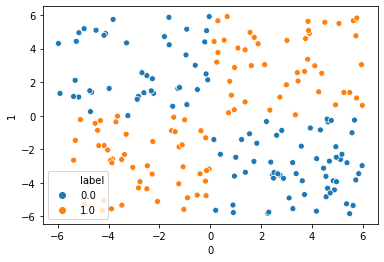

In [11]:
(x_train, y_train) = gen_data()
train_df = get_frame(x_train, y_train)
plot_data(train_df)

In [12]:
train_df.T.describe()

,0,1,label
count,200.000000,200.000000,200.000000
mean,0.536958,-0.274902,0.480000
std,3.482099,3.460336,0.500854
min,-5.970586,-5.839230,0.000000
25%,-2.476407,-3.294592,0.000000
50%,0.609339,-0.368567,0.000000
75%,3.723770,2.502400,1.000000
max,5.984256,5.916529,1.000000


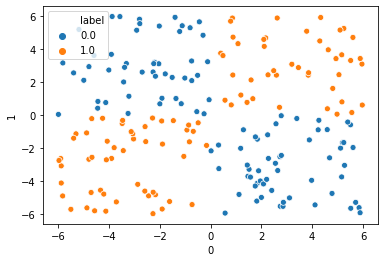

In [13]:
(x_test, y_test) = gen_data()
test_df = get_frame(x_test, y_test)
plot_data(test_df)

In [14]:
test_df.T.describe()

,0,1,label
count,200.000000,200.000000,200.000000
mean,0.071801,-0.207136,0.480000
std,3.492121,3.465453,0.500854
min,-5.992146,-5.975020,0.000000
25%,-2.879010,-2.953782,0.000000
50%,-0.087396,-0.339540,0.000000
75%,2.735230,2.615089,1.000000
max,5.973871,5.952170,1.000000


4. Das in der Vorlesung dargestellte Experiment operiert nicht direkt auf den Inputdaten, sondern auf 2 Merkmale, die mithilfe zweier neuroren mit fixem Gewichtsvektor berechnet werden: ein Neuron teilt die Inputebene waagrecht entlang der x-Achse, das andere senkrecht entlang der y-Achse. Wie muss der Gewichtsvektor für das jeweilige Neuron aussehen?


- Gewichtvektor erstes Neuron [1,0] (entlang x-achse teilen)
- Gewichtsvektor zweites Neuron [0,1] (entlang y-achse teilen)

5. Berechnen Sie die Entscheidungsfunktion beider Neuronen mit der im Beispielcode angegebenen sigmoiden Aktiviterungsfunktion auf einem 100 x 100 Gitter innerhalb des gebiets [-6, 6]x [-6, 6] und stellen Sie diese zur Überprüfung als Farbbild dar.

In [15]:
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x) + (1- sigmoid(x))

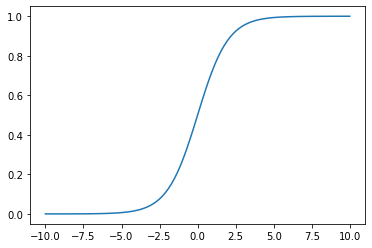

In [16]:
# Sigmoid function
x = np.linspace(-10, 10, 100)
z = sigmoid(x)

plt.plot(x, z)
plt.show()

In [17]:
value_space = np.linspace(-6, 6, 200)
extended_sig = lambda x: sigmoid(np.sqrt(x))
sig_vect = np.vectorize(sigmoid)

In [18]:
def create_grid(dim):
    """
        Create a grid with the given dimensions
    """
    values_direction = np.linspace(-6, 6, dim)
    return np.array(np.meshgrid(values_direction, values_direction)).T.reshape(-1, dim, 2);
    

def calc_activation(weights, activation = sig_vect, shape = (100, 100)):
    """
        Creates an image plot out of given weights.
    
        intput:
         - weights: to use for calculation with dimension (2,)
         - activation: activation function to use in vectorized form
         - shape: shape of grid to be generated
    """
    
    x_dimension, y_dimension = shape
    weights_matrix = np.zeros((x_dimension, 2)) + weights
    
    # Create a grid for calculation
    # values_direction = np.linspace(-6, 6, x_dimension)
    # grid = np.array(np.meshgrid(values_direction, values_direction)).T.reshape(-1, x_dimension, 2)
    
    grid = create_grid(x_dimension)
    
    # Calculate the mse and use sigmoid activation
    weighted_values = grid * weights_matrix # (100, 100, 2)
    summed_values = np.sum(weighted_values, axis = 2) # (100, 100)
    calculated = sig_vect(summed_values) # use activation function on cell values
    return calculated

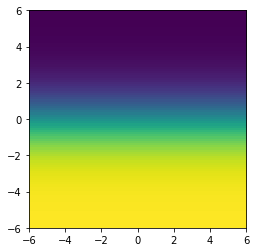

In [19]:
first_neuron_weight = np.array([1, 0])
output_first_neuron = calc_activation(first_neuron_weight)
plt.imshow(output_first_neuron, extent = [-6,6,-6,6]) 

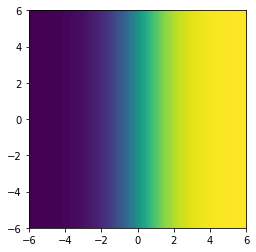

In [20]:
second_neuron_weight = np.array([0,1])
output_sec_neuron = calc_activation(second_neuron_weight)
plt.imshow(output_sec_neuron, extent = [-6,6,-6,6]) 

6. Da die Eingangsneuronen nicht mittrainiert werden, können wir deren Output schon im Vorfeld berechnen. Erzeugen Sie dazu neue Designmatrizen für den Trainings und Testddatensatz, so dass die erste Spalte den Ouput des ersten Neurons und die zweite Spalte den Ouput des zweiten Neurons enhält. Erzeugen Sie auch eine entsprechende Designmatrix für Ihr 100 x 100-Gitter, die wir später zu Darstellungszwecken brauchen werden. Wichtig: arbeiten Sie im Folgenden nur mit diesen transformierten Designmatrizen, um korrekte Ergebenisse zu erhalten!

In [21]:
(x_train, y_train) = gen_data(100)

# Weights for the neurons
weights_first_neuron = np.zeros((100,2)) + np.array([0,1])
weights_second_neuron = np.zeros((100,2)) +np.array([1,0])

# Calculate output values for each neuron
output_first_n = sig_vect(np.sum(x_train * weights_first_neuron, axis = 1))
output_second_n = sig_vect(np.sum(x_train * weights_second_neuron, axis = 1))

In [22]:
output_first_n[:5]

array([0.9114653 , 0.63418127, 0.05554961, 0.89723052, 0.78937035])

In [23]:
output_second_n[:5]

array([0.94785581, 0.99278941, 0.13954158, 0.96735046, 0.81020953])

In [24]:
# Concat neuron output values
input_output_layer = np.vstack((output_first_n, output_second_n)).T
input_output_layer.shape

(100, 2)

In [25]:
# first column (=output first neuron), second colum (=output second neuron) 
input_output_layer[:5]

array([[0.9114653 , 0.94785581],
       [0.63418127, 0.99278941],
       [0.05554961, 0.13954158],
       [0.89723052, 0.96735046],
       [0.78937035, 0.81020953]])

In [26]:
# Create 100x100 grid
grid = np.zeros((100, 100))
grid.shape

(100, 100)

### 2. Training eines MLPs auf den Spelzeugaten
Der Code aus dem Beispielnotebook muss zunächst an das Szenario aus der Vorlesung angepasst werden: ein deutlich kleineres Netzwerk mit eindimensionalen statt zehndimensioanlem Output.

---
Vorgehensweise:
1. Setzten Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatrizen auf Korrektheit.
2. Der Beispielcode verwendet One-Hot-Coding für die Labels in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion `evaluate()` im Code so abändern das , das ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Ouptut kleiner als 0.5 ist und bei Klasse 1 größer als 0.5 Berechnen Sie zusätzlich den MSE in dieser Funktion bei jedem Aufruf und speichern Sie diesen in einem zusätzlichen Array ab.

In [27]:
def weight_init(weight_prev, weight_current):
    return np.random.randn(weight_current, weight_prev) * np.sqrt(2/(weight_prev+weight_current))    

In [28]:
# Netzwerkparameter
x_train, y_train = gen_data(100)
mbs = 10
eta = 0.3
epochs = 150
sizes = [2, 2, 2, 1]
num_layers = len(sizes)     

biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [weight_init(x, y) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

print("Gewicht Matrizen: ")
for weight in weights:
    print(weight.shape)

Gewicht Matrizen: 
(2, 2)
(2, 2)
(1, 2)


In [29]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

In [30]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

In [31]:
correct_label = lambda y, ypred: (int(y) == 1 and float(ypred) >= 0.5) or (int(y) == 0 and float(ypred) < 0.5)
loss = lambda y, ypred: math.pow(y - ypred, 2)

def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    mse = 0 # mean-squared-loss
    global correct_label
    global loss
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # MSE Loss summation
        mse += loss(y, ypred)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if (correct_label(y, ypred)) :
            correct += 1
        
    mse = mse / x2.shape[0]
    
    return (correct, mse)

In [32]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    mse_loss = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        (correct, mse) = evaluate(x2, y2)
        acc_val[j] = correct
        mse_loss[j] = mse
        print("Epoch {0}: {1} / {2} [MSE: {3}]".format(j, acc_val[j], n_test, round(mse_loss[j], 3)))
    
    return (acc_val, mse_loss)

In [33]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

3. Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es
auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar.
Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierung
zuweilen in lokalen Minima hängenbleiben kann. Wiederholen Sie Ihren Versuch daher
mehrere Male und vergeleichen Sie die Ergebnisse.

In [34]:
## Re-initialize weights
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [weight_init(x, y) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

## Alternative paramter (worked to make clear identification)
mbs = 10
epochs = 400
eta = 1.205

# Train network
x_train, y_train = gen_data(200)
x_test, y_test = gen_data(100)
(acc_val, mse_loss) = SGD(x_train, y_train, epochs, mbs, eta, x_test, y_test)

Epoch 0: 58.0 / 100 [MSE: 0.244]
Epoch 1: 55.0 / 100 [MSE: 0.249]
Epoch 2: 58.0 / 100 [MSE: 0.246]
Epoch 3: 42.0 / 100 [MSE: 0.251]
Epoch 4: 58.0 / 100 [MSE: 0.244]
Epoch 5: 58.0 / 100 [MSE: 0.248]
Epoch 6: 42.0 / 100 [MSE: 0.252]
Epoch 7: 58.0 / 100 [MSE: 0.247]
Epoch 8: 58.0 / 100 [MSE: 0.246]
Epoch 9: 74.0 / 100 [MSE: 0.248]
Epoch 10: 61.0 / 100 [MSE: 0.249]
Epoch 11: 58.0 / 100 [MSE: 0.245]
Epoch 12: 58.0 / 100 [MSE: 0.247]
Epoch 13: 58.0 / 100 [MSE: 0.246]
Epoch 14: 58.0 / 100 [MSE: 0.246]
Epoch 15: 58.0 / 100 [MSE: 0.246]
Epoch 16: 60.0 / 100 [MSE: 0.249]
Epoch 17: 58.0 / 100 [MSE: 0.244]
Epoch 18: 58.0 / 100 [MSE: 0.241]
Epoch 19: 58.0 / 100 [MSE: 0.241]
Epoch 20: 58.0 / 100 [MSE: 0.244]
Epoch 21: 58.0 / 100 [MSE: 0.244]
Epoch 22: 58.0 / 100 [MSE: 0.242]
Epoch 23: 58.0 / 100 [MSE: 0.241]
Epoch 24: 42.0 / 100 [MSE: 0.247]
Epoch 25: 58.0 / 100 [MSE: 0.24]
Epoch 26: 58.0 / 100 [MSE: 0.24]
Epoch 27: 81.0 / 100 [MSE: 0.244]
Epoch 28: 58.0 / 100 [MSE: 0.24]
Epoch 29: 81.0 / 100 [MSE: 

Epoch 242: 98.0 / 100 [MSE: 0.013]
Epoch 243: 98.0 / 100 [MSE: 0.013]
Epoch 244: 99.0 / 100 [MSE: 0.009]
Epoch 245: 99.0 / 100 [MSE: 0.009]
Epoch 246: 100.0 / 100 [MSE: 0.007]
Epoch 247: 100.0 / 100 [MSE: 0.007]
Epoch 248: 99.0 / 100 [MSE: 0.008]
Epoch 249: 98.0 / 100 [MSE: 0.014]
Epoch 250: 99.0 / 100 [MSE: 0.009]
Epoch 251: 99.0 / 100 [MSE: 0.01]
Epoch 252: 99.0 / 100 [MSE: 0.011]
Epoch 253: 98.0 / 100 [MSE: 0.012]
Epoch 254: 100.0 / 100 [MSE: 0.007]
Epoch 255: 99.0 / 100 [MSE: 0.012]
Epoch 256: 100.0 / 100 [MSE: 0.009]
Epoch 257: 99.0 / 100 [MSE: 0.012]
Epoch 258: 100.0 / 100 [MSE: 0.006]
Epoch 259: 100.0 / 100 [MSE: 0.007]
Epoch 260: 100.0 / 100 [MSE: 0.007]
Epoch 261: 98.0 / 100 [MSE: 0.013]
Epoch 262: 99.0 / 100 [MSE: 0.009]
Epoch 263: 100.0 / 100 [MSE: 0.007]
Epoch 264: 98.0 / 100 [MSE: 0.012]
Epoch 265: 98.0 / 100 [MSE: 0.013]
Epoch 266: 100.0 / 100 [MSE: 0.008]
Epoch 267: 99.0 / 100 [MSE: 0.009]
Epoch 268: 99.0 / 100 [MSE: 0.009]
Epoch 269: 100.0 / 100 [MSE: 0.007]
Epoch 270: 

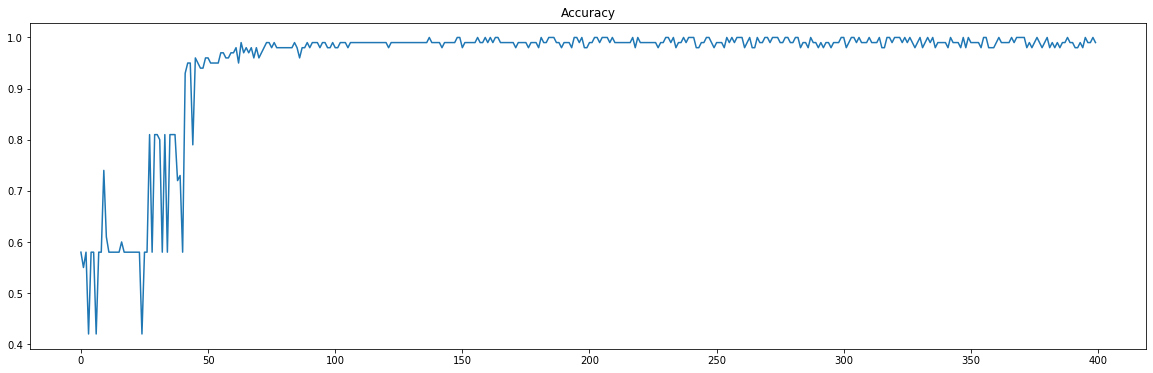

In [35]:
fig = plt.figure(figsize=(20, 6))
plt.title("Accuracy")
plt.plot(acc_val/x.shape[0])

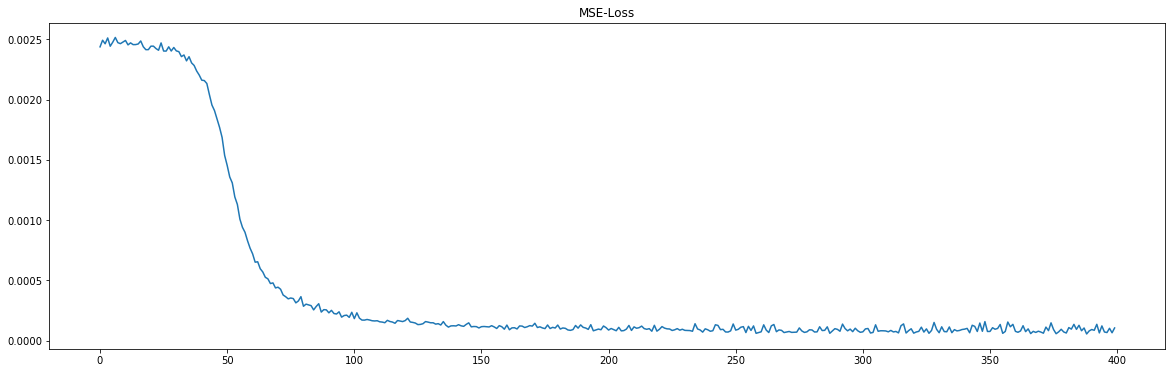

In [36]:
fig = plt.figure(figsize=(20,6))
plt.title("MSE-Loss")
plt.plot(mse_loss/x.shape[0])

4. Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 × 100-Gitter und
stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

In [37]:
# Create a grid to see generalization
new_grid = create_grid(100)
grid_x = new_grid.reshape(100*100, 2) # reshape values so that they are processable by evaluate
grid_x.shape

(10000, 2)

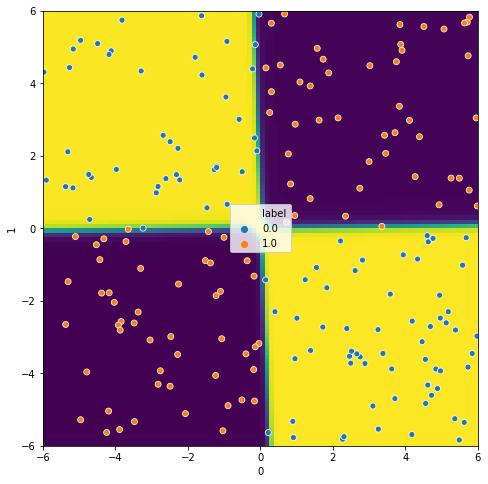

In [38]:
results = np.zeros(grid_x.shape[0])
for j in range(grid_x.shape[0]):
    x = np.reshape(grid_x[j,:],(grid_x.shape[1],1)).copy()
    new_res = feedforward(x)
    results[j] = float(new_res)

# Reshape to get plot background
background_plot = results.reshape(100, 100)
fig = plt.figure(figsize = (8, 8))
plot_data(train_df)
plt.imshow(background_plot, extent = [-6,6,-6,6]) 

### 3. Nachvolziehen der Beispiele aus der Vorlesung
Das Netz aus der Vorlesung verwendet als Aktivierungsfuntkion den *Tangens-hyperbolicus* (`np.tanh()`). Passen Sie die Funktion `sigmoid()` und `sigmoid_prime()` entsprechend an. 

**Achtung:** kommentieren Sie den bisherigen Code für die Sigmoidfunktion nur aus, wir werden ihn in der nächsten Aufgabe nochmals benötigen. Da die Ausgangswerte von *tanh* im Intervall [-1,1] statt [0,1] liegen, müsssen wir hierfür nochmals die Funktion `evaluate()` enstsprechend anpassen. Vollziehen Sie die 3 Beispiele aus der Vorlesung nach.

In [39]:
x

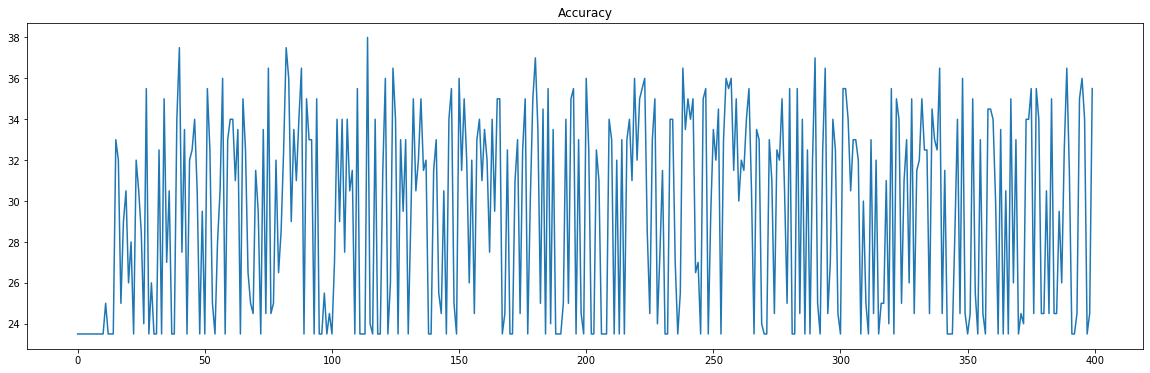

In [41]:
fig = plt.figure(figsize=(20, 6))
plt.title("Accuracy")
plt.plot(acc_val/x.shape[0])

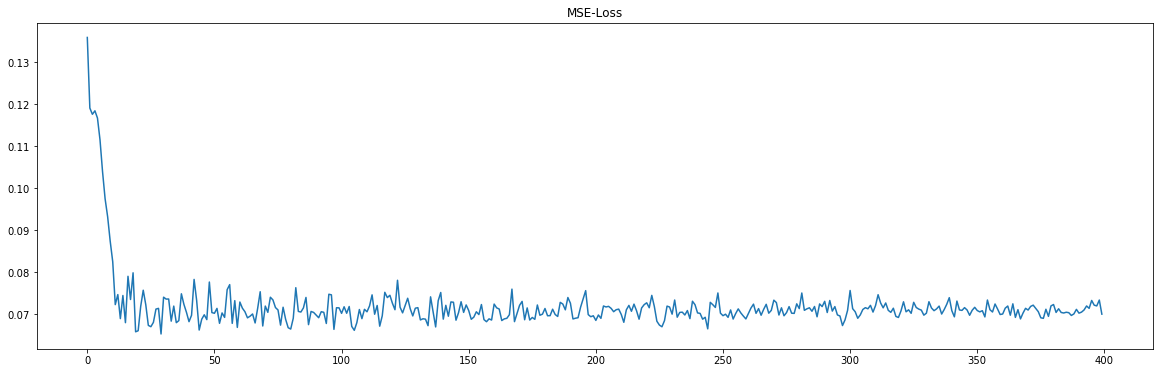

In [42]:
fig = plt.figure(figsize=(20,6))
plt.title("MSE-Loss")
plt.plot(mse_loss/x.shape[0])

In [54]:
import mlp
importlib.reload(mlp)

# Parameters
mbs = 10
eta = 1.2
epochs = 150
sizes = [2, 2, 2, 1]

mlp = mlp.MLP(sizes)
mlp.fit(epochs = epochs, mini_batch_size = mbs, eta = eta)
x_train, y_train = gen_data(200)
x_test, y_test = gen_data(100)
(acc, loss) = mlp.train(x_train, y_train, x_test, y_test)

Epoch 0: 48.0 / 100 [MSE: 0.251]
Epoch 1: 52.0 / 100 [MSE: 0.25]
Epoch 2: 52.0 / 100 [MSE: 0.251]
Epoch 3: 52.0 / 100 [MSE: 0.251]
Epoch 4: 52.0 / 100 [MSE: 0.251]
Epoch 5: 48.0 / 100 [MSE: 0.252]
Epoch 6: 52.0 / 100 [MSE: 0.25]
Epoch 7: 52.0 / 100 [MSE: 0.251]
Epoch 8: 51.0 / 100 [MSE: 0.25]
Epoch 9: 52.0 / 100 [MSE: 0.25]
Epoch 10: 52.0 / 100 [MSE: 0.25]
Epoch 11: 48.0 / 100 [MSE: 0.251]
Epoch 12: 50.0 / 100 [MSE: 0.25]
Epoch 13: 52.0 / 100 [MSE: 0.25]
Epoch 14: 52.0 / 100 [MSE: 0.25]
Epoch 15: 48.0 / 100 [MSE: 0.251]
Epoch 16: 52.0 / 100 [MSE: 0.25]
Epoch 17: 40.0 / 100 [MSE: 0.25]
Epoch 18: 52.0 / 100 [MSE: 0.25]
Epoch 19: 52.0 / 100 [MSE: 0.25]
Epoch 20: 52.0 / 100 [MSE: 0.25]
Epoch 21: 52.0 / 100 [MSE: 0.25]
Epoch 22: 48.0 / 100 [MSE: 0.251]
Epoch 23: 52.0 / 100 [MSE: 0.25]
Epoch 24: 52.0 / 100 [MSE: 0.251]
Epoch 25: 48.0 / 100 [MSE: 0.25]
Epoch 26: 52.0 / 100 [MSE: 0.25]
Epoch 27: 52.0 / 100 [MSE: 0.25]
Epoch 28: 52.0 / 100 [MSE: 0.25]
Epoch 29: 48.0 / 100 [MSE: 0.251]
Epoch 30:

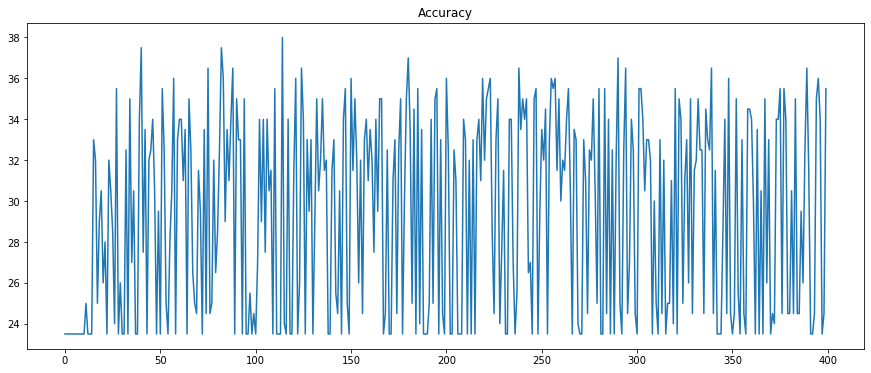

In [55]:
fig = plt.figure(figsize=(15, 6))
plt.title("Accuracy")
plt.plot(acc_val/x.shape[0])

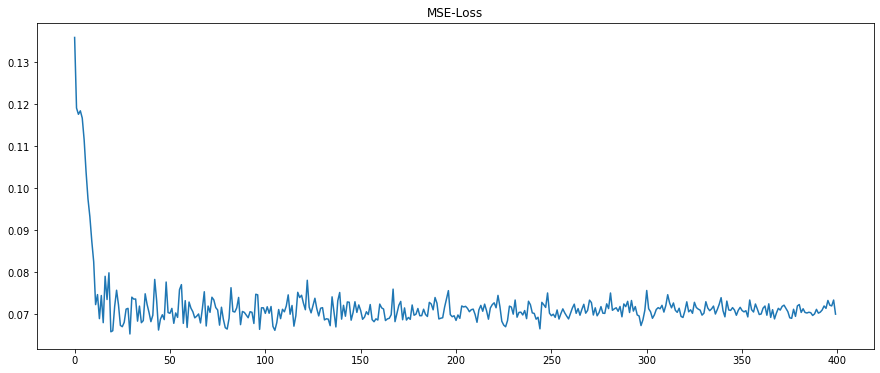

In [56]:
fig = plt.figure(figsize=(15,6))
plt.title("MSE-Loss")
plt.plot(mse_loss/x.shape[0])

### 4. Logistische Regression
Eine alternative, besser an das Klassifikationsszenario angepasst Kostenfunktion statt des MSE ist die Kostenfunktion für die logisitische Regression: 

$C$ = -*y* log($a^l$) - (1 - *y*) log(1 - $a^l$)

Damit Sie diese in Ihrem Beispiel anweden können, müssen Sie die Ableitung $\nabla$<sub>$a^L$</sub>$C$ berechnen und die Funktion `cost_derivative()` entsprechend abändern. Da die logistische Regression davon ausgeht, dass der Output des Netzes eine Wahrscheinlichkeit zwischen 0 und 1 ist, können wir hierfür nicht den `tanh()` als Aktivierungsfunktion verwenden. Machen Sie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoide Aktivierungsfunktion haben. In der Funktion `evaluate()` sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen ob tatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl auf $C$ wie auf $\nabla$<sub>$a_{L}$</sub>$C$ die Funktion `np.nan_to_num()` anzuwenden, da hier zuweilen numerische Probleme auftreten können.

In [44]:
def logistic_regression_loss(y, ypred):
    pass


In [45]:
# Reset parameters

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))


correct_label = lambda y, ypred: (int(y) == 1 and float(ypred) >= 0.5) or (int(y) == 0 and float(ypred) < 0.5)


def cost_derivative(output_activations, y):
    return (output_activations-y)